## Data Splitting for Open-Set Re-Identification: A Comprehensive Guide

This notebook documents the crucial data splitting strategy employed for evaluating an open-set re-identification (re-ID) model, specifically designed for wildlife datasets.  The goal is to accurately assess the model's ability to both re-identify *known* individuals (those seen during training) and to recognize *new, unseen* individuals – a challenging but realistic scenario in wildlife monitoring.

### I. The Challenge: Open-Set vs. Closed-Set Re-ID

Traditional (closed-set) re-ID assumes that all individuals appearing in the test set are also present in the training set (though with different images).  Open-set re-ID relaxes this assumption.  In an open-set setting, the model must:

1.  **Re-identify Known Individuals:**  Correctly match new images of individuals that were seen during training.
2.  **Recognize Unknown Individuals:**  Identify images of individuals *not* seen during training as belonging to a *new* individual (not one of the known ones).

This is significantly harder than closed-set re-ID.  A model that simply memorizes training images would fail completely on the open-set task.

### II. Key Concepts and Metrics

*   **BAKS (Balanced Accuracy on Known Samples):**  Measures the accuracy of the model in re-identifying individuals that were present in the training data.  It's "balanced" because it considers the accuracy for each individual separately and then averages, preventing bias towards individuals with many images.

*   **BAUS (Balanced Accuracy on Unknown Samples):** Measures the accuracy of the model in correctly identifying images of individuals *not* present in the training data as belonging to "unknown" individuals. This is the core metric for open-set performance.

*   **Geometric Mean:** The final performance metric is the geometric mean of BAKS and BAUS: `sqrt(BAKS * BAUS)`.  This is used instead of the arithmetic mean to penalize models that perform well on only one of the tasks (e.g., a model that always predicts "unknown" would have 100% BAUS but 0% BAKS, leading to a 0% geometric mean).

*    **Individuals vs. Images:** It's *crucial* to distinguish between individuals (unique animals) and images (photos of those animals). The split is performed at the *individual* level, but evaluation considers both individual-level and image-level correctness.

### III. The Splitting Strategy: Ensuring a Valid and Unbiased Evaluation

To properly evaluate both BAKS and BAUS, we need a specific data splitting strategy. A simple random split of images is insufficient because it would likely lead to images of the *same* individual appearing in both the training and test sets, creating data leakage and artificially inflating performance.

**The Core Principles:**

1.  **Individual-Based Splitting:** The data is split into three sets (Training, Validation, and Test) primarily based on individual IDs. All images of unknown individuals are assigned to the same split (either Validation or Test, but never Train). For known individuals (those present in the Training set), their images are further split across the Training, Validation, and Test sets, ensuring that no single image appears in more than one set. This prevents data leakage and allows for a valid evaluation of both BAKS and BAUS.

2.  **Known and Unknown Subsets:** The Validation and Test sets each contain two subsets of individuals:
    *   **Known Individuals:**  Individuals that are *also* present in the Training set. These are used to evaluate BAKS.
    *   **Unknown Individuals:** Individuals that are *completely distinct* from those in the Training set.  These are used to evaluate BAUS.

3.  **Image-Level Separation (Within Known Individuals):** Even for the "known" individuals that appear in multiple sets, the *specific images* of those individuals must be different across the Train, Validation, and Test sets. This prevents the model from overfitting to specific images and ensures a realistic evaluation.

**The Splitting Process (High-Level):**

1. **Initial Split:** First divide all of our unique individual IDs into two disjoint sets: *train*, and *temp_test*.
2. **Further split** the set *temp_test* into two disjoint sets *val_unknown* and *test_unknown*.
3.  **Image Split (Known Individuals):**
    * Iterate over the set of unique train individual IDs.
    * Get all of the images that the individual appears in.
    * Split the images up into those that will be in the training set, those that will be in the validation set, and those that will be in the test set.

**Detailed Breakdown and Code Implementation**
This part is done by using the `split_reid_data` function.

**IV. Data Split Summary**

The resulting split has the following structure:
| Split       | Num Individuals | Num Images | Known Individuals | Unknown Individuals | Purpose                                                                                                                                                             |
|-------------|-----------------|------------|-------------------|---------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Train       | 404             | 3392         |      404             |      0                | Used to train the re-identification model to distinguish between the known individuals.                                                                                |
| Validation  |      458           |  2575          |        404           |      54                | Used for hyperparameter tuning and model selection. BAKS is calculated on the known individuals, BAUS on the unknown individuals.                                          |
| Test        |      620         |       6568     |    404               |      216          | Used for *final, unbiased* performance evaluation. BAKS is calculated on the known individuals, BAUS on the unknown individuals. This reflects real-world performance. |


**V. Key Considerations and Potential Issues**

*   **Image Count Filtering:**  Individuals with very few images (e.g., only one or two) can negatively impact model training and evaluation. We filter out these individuals *after* the initial individual-level split, but *before* the image-level split within the known individuals.
*   **Data Augmentation:** Data augmentation techniques (e.g., rotations, flips, color adjustments) can be used to increase the effective size of the training set.  However, augmentation must be applied *carefully* to avoid introducing artificial correlations that could lead to data leakage.  Augmentation should be applied *after* the train/validation/test split.
* **No Overlap of Images**: there is no overlap of image ids between any split.

By adhering to this rigorous splitting strategy, we ensure a valid, unbiased, and informative evaluation of our open-set re-ID model, providing a realistic assessment of its performance in a challenging wildlife monitoring context.


In [1]:
%load_ext autoreload
%autoreload 2
from animalclef.spark import get_spark
from pyspark.sql import functions as F, Window
from pathlib import Path
import matplotlib.pyplot as plt

spark = get_spark(cores=4, memory="10g")
display(spark)

metadata = spark.read.parquet(f"{Path.home()}/shared/animalclef/data/parquet/metadata")
embeddings = spark.read.parquet(
    f"{Path.home()}/shared/animalclef/data/embeddings/dinov2"
)
df = metadata.join(embeddings, on="image_id")
df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/13 02:14:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/13 02:14:35 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


root
 |-- image_id: integer (nullable = true)
 |-- identity: string (nullable = true)
 |-- path: string (nullable = true)
 |-- date: date (nullable = true)
 |-- orientation: string (nullable = true)
 |-- species: string (nullable = true)
 |-- split: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- token: struct (nullable = true)
 |    |-- cls: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- avg_patch: array (nullable = true)
 |    |    |-- element: float (containsNull = true)



In [2]:
display(df.select("identity").distinct().count())
df.groupBy("identity").count().describe().show()

1103

+-------+--------------------+------------------+
|summary|            identity|             count|
+-------+--------------------+------------------+
|  count|                1102|              1103|
|   mean|                NULL|13.788757932910245|
| stddev|                NULL| 68.53376094252918|
|    min|  LynxID2025_lynx_00|                 1|
|    max|SeaTurtleID2022_t610|              2135|
+-------+--------------------+------------------+



+----+-----+
|freq|count|
+----+-----+
|   1|  317|
|   2|  111|
|   3|   79|
|   4|   58|
|   5|   66|
|   6|   44|
|   7|   39|
|   8|   32|
|   9|   33|
|  10|   17|
|  11|   18|
|  12|   13|
|  13|   19|
|  14|   13|
|  15|   16|
|  16|   12|
|  17|    9|
|  18|   15|
|  19|   12|
|  20|   10|
+----+-----+
only showing top 20 rows



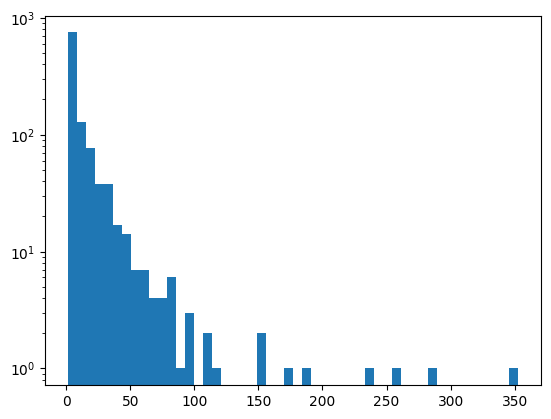

In [3]:
counts = (
    df.where("identity is not null")
    .groupBy("identity")
    .count()
    .withColumnRenamed("count", "freq")
).cache()
counts.groupBy("freq").count().orderBy("freq").show()

plt.hist(counts.toPandas().freq, bins=50, log=True)
plt.show()

In [4]:
# add a new column for identity count
pdf = df.select(
    "image_id",
    "identity",
    "dataset",
    "token.*",
    F.count("image_id").over(Window.partitionBy("identity")).alias("identity_count"),
).toPandas()
pdf.head()

,image_id,identity,dataset,cls,avg_patch,identity_count
0,3414,LynxID2025_lynx_04,LynxID2025,"[1.953707, -0.06146222, -1.966017, -0.31764427...","[0.47695184, -0.74326456, -0.82782966, -0.7631...",3
1,472,LynxID2025_lynx_04,LynxID2025,"[1.3321328, -2.366122, -3.25668, 0.5420925, 0....","[0.6709354, -0.65619326, -0.81696904, -0.69181...",3
2,329,LynxID2025_lynx_04,LynxID2025,"[2.5965683, -0.9103739, -1.8469927, -1.1413739...","[1.1247859, -0.4730551, -0.87914395, -1.143541...",3
3,2264,LynxID2025_lynx_08,LynxID2025,"[1.7082918, -2.1121547, -1.5560057, -0.0668072...","[1.064861, -1.0406678, -0.5095228, -0.78655636...",1
4,717,LynxID2025_lynx_16,LynxID2025,"[2.0524616, -3.7293742, 0.29863188, 2.1957643,...","[0.89284337, -1.0155127, -0.25687754, -0.20243...",36


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


def split_reid_data(
    df: pd.DataFrame,
    train_ratio: float = 0.6,
    val_ratio: float = 0.2,
    known_ratio: float = 0.5,  # Ratio of *images* of known indivs for val/test
    group_col: str = "identity",
    image_col: str = "image_id",
    seed: int = 42,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # 1. Split into Train and (Temp) Test sets based on individuals (groups)
    unique_ids = df[group_col].unique()
    train_ids, temp_test_ids = train_test_split(
        unique_ids, train_size=train_ratio, random_state=seed
    )

    # 2. Split (Temp) Test into Validation and Final Test sets (unknown individuals).
    val_unknown_ids, test_unknown_ids = train_test_split(
        temp_test_ids, train_size=val_ratio, random_state=seed + 1
    )
    # 3. Split *images* of known individuals.
    val_known_images = []
    test_known_images = []
    train_images = []
    for indiv_id in sorted(train_ids):
        images = df[df[group_col] == indiv_id][image_col].tolist()
        if len(images) > 1:  # Only split if more than 1 image
            known, unknown = train_test_split(
                images, test_size=1 - known_ratio, random_state=seed + 2
            )
            val_known, test_known = train_test_split(
                unknown, test_size=0.5, random_state=seed + 3
            )

            val_known_images.extend(val_known)
            test_known_images.extend(test_known)
            train_images.extend(known)
        else:  # If only 1 image, put it in the validation set (or test, doesn't matter much)
            val_known_images.extend(images)

    # Create the known and unknown dfs
    val_df_known = df[df[image_col].isin(val_known_images)]
    test_df_known = df[df[image_col].isin(test_known_images)]
    train_df = df[df[image_col].isin(train_images)]
    val_df_unknown = df[df[group_col].isin(val_unknown_ids)]
    test_df_unknown = df[df[group_col].isin(test_unknown_ids)]

    # 4. Combine to create final DataFrames
    val_df = pd.concat([val_df_known, val_df_unknown])
    test_df = pd.concat([test_df_known, test_df_unknown])

    return train_df, val_df, test_df


def summarize_split(train_df, val_df, test_df, id_col="identity", image_col="image_id"):
    summary = pd.DataFrame(
        {
            "Split": ["Train", "Validation", "Test"],
            "Num Individuals": [
                train_df[id_col].nunique(),
                val_df[id_col].nunique(),
                test_df[id_col].nunique(),
            ],
            "Num Images": [len(train_df), len(val_df), len(test_df)],
        }
    )

    train_ids = set(train_df[id_col])
    val_ids = set(val_df[id_col])
    test_ids = set(test_df[id_col])

    # Image overlaps (using set operations on image IDs)
    train_images = set(train_df[image_col])
    val_images = set(val_df[image_col])
    test_images = set(test_df[image_col])

    summary["Train Image Overlap"] = [
        len(train_images.intersection(train_images)),
        len(train_images.intersection(val_images)),
        len(train_images.intersection(test_images)),
    ]
    summary["Val Image Overlap"] = [
        len(val_images.intersection(train_images)),
        len(val_images.intersection(val_images)),
        len(val_images.intersection(test_images)),
    ]
    summary["Test Image Overlap"] = [
        len(test_images.intersection(train_images)),
        len(test_images.intersection(val_images)),
        len(test_images.intersection(test_images)),
    ]

    # now get the percentages of each of these
    summary["Train Image %"] = (
        summary["Train Image Overlap"] / len(train_images) * 100
    ).round(2)
    summary["Val Image %"] = (
        summary["Val Image Overlap"] / len(val_images) * 100
    ).round(2)
    summary["Test Image %"] = (
        summary["Test Image Overlap"] / len(test_images) * 100
    ).round(2)

    # Add Known/Unknown Counts to Summary (NEW)
    summary["Known Individuals"] = [
        len(train_ids),
        len(val_ids.intersection(train_ids)),
        len(test_ids.intersection(train_ids)),
    ]
    summary["Unknown Individuals"] = [
        0,  # No unknowns in training
        len(val_ids - train_ids),
        len(test_ids - train_ids),
    ]
    return summary


cond = (~pdf.identity.isnull()) & (pdf.identity_count > 2)
train_df, val_df, test_df = split_reid_data(pdf[cond])
summary_table = summarize_split(train_df, val_df, test_df)
summary_table

,image_id,identity,dataset,cls,avg_patch,identity_count
7,3113,LynxID2025_lynx_16,LynxID2025,"[-1.2353026, -0.20536101, 0.61724025, 1.355893...","[0.23009793, -0.599779, 0.09589866, -1.018367,...",36
8,2766,LynxID2025_lynx_16,LynxID2025,"[1.1601936, -0.30430153, -3.4015892, 0.7278578...","[1.0587692, 0.15164235, -0.14883831, -1.105805...",36
10,1092,LynxID2025_lynx_16,LynxID2025,"[1.6077322, -2.6395178, -2.5117278, 1.3201498,...","[0.94769865, -0.7683547, 0.045931105, -0.43619...",36
11,2863,LynxID2025_lynx_16,LynxID2025,"[2.9512155, -1.2826347, -0.9431905, -0.3966249...","[0.987959, -0.4492482, -0.5739524, -1.4712, 1....",36
14,3546,LynxID2025_lynx_16,LynxID2025,"[4.8651624, -3.594092, 0.5640984, 0.20187731, ...","[0.94039714, -0.7215976, -0.038915355, 0.04608...",36


,Split,Num Individuals,Num Images,Train Image Overlap,Val Image Overlap,Test Image Overlap,Train Image %,Val Image %,Test Image %,Known Individuals,Unknown Individuals
0,Train,404,3392,3392,0,0,100.0,0.0,0.0,404,0
1,Validation,458,2575,0,2575,0,0.0,100.0,0.0,404,54
2,Test,620,6568,0,0,6568,0.0,0.0,100.0,404,216
